# Digit Recognition Kaggle Competition

The goal of this competition is to use classification methods to correctly identify digits from handwritten images. This notebook originated as an assignment from my Data Science Immersive with General Assembly.

In [95]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import make_classification, make_regression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from tensorflow.python.keras import utils
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.utils import to_categorical
from sklearn.svm import SVC

In [96]:
data = pd.read_csv('train.csv')
data.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [97]:
data.shape

(42000, 785)

In [98]:
# Define X and y
X = data.drop(columns=['label'])
y = data['label']

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [99]:
# find the highest value in the datasets
X_train.max().max(), X_test.max().max()

(255, 255)

In [100]:
# find the lowest value in the dataset
X_train.min().min(), X_test.min().min()

(0, 0)

# Preprocessing

### Scaling
To improve computational efficiency, scale the data from 0 to 1.

In [101]:
# Make sure each value is a float and scale
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

X_train /= 255
X_test /= 255

In [102]:
# Change X train and X test to an array
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()

In [103]:
# Check shape of full training data.
# this is the number of images by 28**2
X_train.shape

(31500, 784)

### Reshape 

The neural networks require the input data to have 4 dimensions _(batch_size, height, width, depth)_. The depth dimension represents the number of color channels, or how dark the pixel is (in this case 1 for greyscale rather than 3 for an RGB image).

In [104]:
# Reshape for neural net 31500 x 28 x 28 x 1.
X_train_nn = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test_nn = X_test.reshape(X_test.shape[0], 28, 28, 1)

X_train_nn.shape

(31500, 28, 28, 1)

### Encode target variable
Since this is a multiclass classification problem, the target variable needs to be categorical or the neural network will try to make predictions based on what is numerically close to the true value.

In [105]:
# one hot encode the target variables - there are 10 digit categories
y_train_nn = utils.to_categorical(y_train, 10)
y_test_nn = utils.to_categorical(y_test, 10)

In [106]:
# Check y_train. Now its a one hot encoded array
y_train_nn[0:10]

array([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]], dtype=float32)

# Modeling

## Support Vector Machine
Test a SVM model, which is a more general form of a support vector classifier that can have non-linear separation between classes. 

In [159]:
# Gridsearch over different hyperparameters

svc_params={
    'kernel':['poly','rbf','sigmoid'],
    'C':[0.1,1,2],
    'gamma':['scale']}

# Fit to training data
svc_gs=GridSearchCV(SVC(random_state=42),
                    param_grid=svc_params,
                    cv=3)

svc_gs.fit(X_train, y_train)

In [ ]:
# Evaluate model
print(f"Test score: {svc_gs.score(X_train, y_train)}")
print(f"Test score: {svc_gs.score(X_test, y_test)}")
print(f"Best params: {svc_gs.best_params_}")

## Keras Sequential Model

In [142]:
sq_model = Sequential()

In [143]:
# Add a flatten layer before dense layers
sq_model.add(Flatten(input_shape=(28,28,1)))

# Create the network
sq_model.add(Dense(128, activation='relu'))
sq_model.add(Dense(64, activation='relu'))
sq_model.add(Dense(32, activation='relu'))
sq_model.add(Dense(10, activation='softmax'))

# Compile model
sq_model.compile(loss='categorical_crossentropy',
                 optimizer='adam',
                 metrics=['accuracy'])

In [144]:
# Fit to training data
history_sq = sq_model.fit(X_train_nn,
                    y_train_nn, 
                    batch_size=256, 
                    validation_data=(X_test_nn, y_test_nn),
                    epochs=5,
                    verbose=1)

Train on 31500 samples, validate on 10500 samples
Epoch 1/5
31500/31500 [==============================] - 7s 234us/sample - loss: 0.5964 - accuracy: 0.8252 - val_loss: 0.2646 - val_accuracy: 0.9249
Epoch 2/5
31500/31500 [==============================] - 2s 76us/sample - loss: 0.2119 - accuracy: 0.9386 - val_loss: 0.1900 - val_accuracy: 0.9449
Epoch 3/5
31500/31500 [==============================] - 2s 75us/sample - loss: 0.1563 - accuracy: 0.9546 - val_loss: 0.1688 - val_accuracy: 0.9491
Epoch 4/5
31500/31500 [==============================] - 3s 87us/sample - loss: 0.1233 - accuracy: 0.9635 - val_loss: 0.1564 - val_accuracy: 0.9565
Epoch 5/5
31500/31500 [==============================] - 3s 95us/sample - loss: 0.1048 - accuracy: 0.9690 - val_loss: 0.1260 - val_accuracy: 0.9631


In [145]:
sq_model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_9 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_27 (Dense)             (None, 128)               100480    
_________________________________________________________________
dense_28 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_29 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_30 (Dense)             (None, 10)                330       
Total params: 111,146
Trainable params: 111,146
Non-trainable params: 0
_________________________________________________________________


## Keras Convolutional Model

In [146]:
# Instantiate a CNN.
cnn_model = Sequential()

In [147]:
# Create the network

# Add convolutional layers.
cnn_model.add(Conv2D(filters = 6,           
                     kernel_size = (3,3),       
                     activation='relu',       
                     input_shape=(28,28,1))) 

cnn_model.add(MaxPooling2D(pool_size=(2,2)))

cnn_model.add(Conv2D(filters= 16,
                     kernel_size=(3,3),
                     activation='relu'))

cnn_model.add(MaxPooling2D(pool_size=(2,2)))

# Add a flatten layer before dense layers
cnn_model.add(Flatten())

# Add densely-connected layers
cnn_model.add(Dense(128, activation='relu'))
cnn_model.add(Dense(10,activation='softmax'))

In [148]:
# Compile model
cnn_model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

In [149]:
# Fit model on training data
history_cnn = cnn_model.fit(X_train_nn,
                        y_train_nn,
                        batch_size=256,
                        validation_data=(X_test_nn, y_test_nn),
                        epochs=5,
                        verbose=1)

Train on 31500 samples, validate on 10500 samples
Epoch 1/5
31500/31500 [==============================] - 26s 825us/sample - loss: 0.7140 - accuracy: 0.8130 - val_loss: 0.2455 - val_accuracy: 0.9267
Epoch 2/5
31500/31500 [==============================] - 22s 693us/sample - loss: 0.1850 - accuracy: 0.9456 - val_loss: 0.1467 - val_accuracy: 0.9579
Epoch 3/5
31500/31500 [==============================] - 21s 680us/sample - loss: 0.1275 - accuracy: 0.9615 - val_loss: 0.1103 - val_accuracy: 0.9681
Epoch 4/5
31500/31500 [==============================] - 23s 720us/sample - loss: 0.0949 - accuracy: 0.9709 - val_loss: 0.0922 - val_accuracy: 0.9712
Epoch 5/5
31500/31500 [==============================] - 22s 696us/sample - loss: 0.0838 - accuracy: 0.9743 - val_loss: 0.0769 - val_accuracy: 0.9770


In [150]:
# Check out the model summary.
cnn_model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 26, 26, 6)         60        
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 13, 13, 6)         0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 11, 11, 16)        880       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 5, 5, 16)          0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 400)               0         
_________________________________________________________________
dense_31 (Dense)             (None, 128)               51328     
_________________________________________________________________
dense_32 (Dense)             (None, 10)               

## Dropout Regularization

The first iteration was quite underfit, so I decreased the batch size and increased the number of epochs.

In [151]:
# Instantiate a CNN.
cnn_model_2 = Sequential()

# Add convolutional layers.
cnn_model_2.add(Conv2D(filters=6,       
                       kernel_size = (3,3),  
                       activation = 'relu',  
                       input_shape = (28,28,1))) 


cnn_model_2.add(MaxPooling2D(pool_size = (2,2))) 


cnn_model_2.add(Conv2D(filters=64,
                       kernel_size = (3,3),
                       activation = 'relu'))

cnn_model_2.add(MaxPooling2D(pool_size = (2,2)))

# Flatten
cnn_model_2.add(Flatten())

# Add Dropout
cnn_model_2.add(Dense(64, activation='relu'))
cnn_model_2.add(Dropout(0.5))
cnn_model_2.add(Dense(32, activation='relu'))
cnn_model_2.add(Dropout(0.5))
cnn_model_2.add(Dense(10, activation='softmax'))

# Compile model
cnn_model_2.compile(loss='categorical_crossentropy',
                    optimizer='adam',
                    metrics=['accuracy'])

In [152]:
# Fit model on training data
history_cnn2 = cnn_model_2.fit(X_train_nn,
                          y_train_nn,
                          batch_size = 206,
                          validation_data = (X_test_nn, y_test_nn),
                          epochs=7,
                          verbose=1)

Train on 31500 samples, validate on 10500 samples
Epoch 1/7
31500/31500 [==============================] - 30s 939us/sample - loss: 1.4530 - accuracy: 0.4907 - val_loss: 0.3369 - val_accuracy: 0.9320
Epoch 2/7
31500/31500 [==============================] - 28s 889us/sample - loss: 0.6992 - accuracy: 0.7713 - val_loss: 0.1789 - val_accuracy: 0.9563
Epoch 3/7
31500/31500 [==============================] - 28s 879us/sample - loss: 0.4966 - accuracy: 0.8416 - val_loss: 0.1334 - val_accuracy: 0.9642
Epoch 4/7
31500/31500 [==============================] - 26s 810us/sample - loss: 0.4203 - accuracy: 0.8655 - val_loss: 0.1165 - val_accuracy: 0.9686
Epoch 5/7
31500/31500 [==============================] - 25s 799us/sample - loss: 0.3808 - accuracy: 0.8786 - val_loss: 0.0975 - val_accuracy: 0.9747
Epoch 6/7
31500/31500 [==============================] - 26s 824us/sample - loss: 0.3430 - accuracy: 0.8893 - val_loss: 0.0921 - val_accuracy: 0.9752
Epoch 7/7
31500/31500 [===========================

In [153]:
# Instantiate
sq_model_2 = Sequential()

# Add a flatten layer before dense layers
sq_model_2.add(Flatten(input_shape=(28,28,1)))

# Add Dropout
sq_model_2.add(Dense(128, activation='relu'))
sq_model_2.add(Dropout(0.5))
sq_model_2.add(Dense(64, activation='relu'))
sq_model_2.add(Dropout(0.5))
sq_model_2.add(Dense(32, activation='relu'))
sq_model_2.add(Dropout(0.5))
sq_model_2.add(Dense(10, activation='softmax'))

# Compile model
sq_model_2.compile(loss='categorical_crossentropy',
                    optimizer='adam',
                    metrics=['accuracy'])

In [154]:
# Fit to training data
history_sq2 = sq_model_2.fit(X_train_nn,
                            y_train_nn, 
                            batch_size=126, 
                            validation_data=(X_test_nn, y_test_nn),
                            epochs=10,
                            verbose=1)

Train on 31500 samples, validate on 10500 samples
Epoch 1/10
31500/31500 [==============================] - 8s 241us/sample - loss: 1.5561 - accuracy: 0.4499 - val_loss: 0.5529 - val_accuracy: 0.8638
Epoch 2/10
31500/31500 [==============================] - 4s 137us/sample - loss: 0.7999 - accuracy: 0.7453 - val_loss: 0.3357 - val_accuracy: 0.9135
Epoch 3/10
31500/31500 [==============================] - 5s 161us/sample - loss: 0.6219 - accuracy: 0.8176 - val_loss: 0.2664 - val_accuracy: 0.9281
Epoch 4/10
31500/31500 [==============================] - 5s 144us/sample - loss: 0.5266 - accuracy: 0.8535 - val_loss: 0.2339 - val_accuracy: 0.9372
Epoch 5/10
31500/31500 [==============================] - 4s 116us/sample - loss: 0.4647 - accuracy: 0.8723 - val_loss: 0.2075 - val_accuracy: 0.9447
Epoch 6/10
31500/31500 [==============================] - 4s 115us/sample - loss: 0.4309 - accuracy: 0.8819 - val_loss: 0.1972 - val_accuracy: 0.9489
Epoch 7/10
31500/31500 [==========================

### Visualize Results

In [155]:
# synthesize in function
def plot_losses(history, model, color1, color2):
    train_loss = history.history['loss']
    test_loss = history.history['val_loss']
    plt.plot(train_loss, label=f"Training Loss {model}", color=color1)
    plt.plot(test_loss, label=f"Test Loss {model}", color=color2)

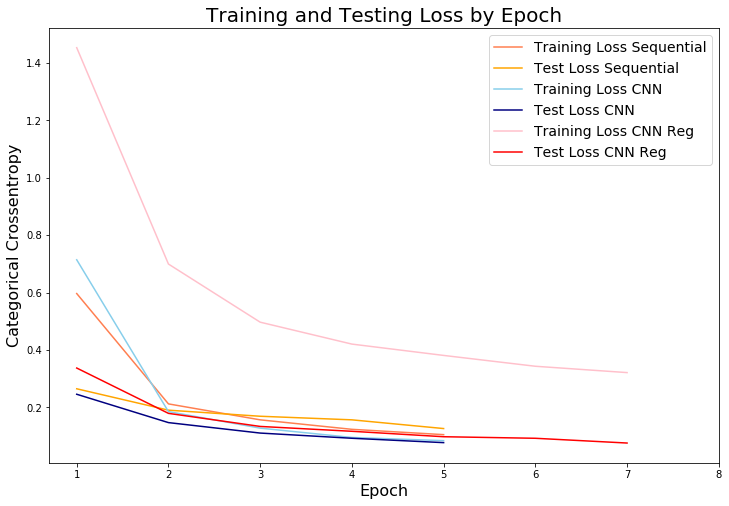

In [158]:
# Set figure size.
plt.figure(figsize=(12,8))

plot_losses(history_sq, 'Sequential', 'coral', 'orange')
plot_losses(history_cnn, 'CNN', 'skyblue', 'navy')
plot_losses(history_cnn2, 'CNN Reg', 'pink', 'red')


# Set title
plt.title('Training and Testing Loss by Epoch', fontsize=20)
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Categorical Crossentropy', fontsize=16)
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7], [1, 2, 3, 4, 5, 6, 7, 8])

plt.legend(fontsize=14);

# Evaluate

In [22]:
# read in test dataset
kaggle_test = pd.read_csv('test.csv')
kaggle_test.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [23]:
# Apply the same preprocessing steps
kaggle_test = kaggle_test.astype('float32')

# Scaling
kaggle_test /= 255

# Change to a numpy array
kaggle_test = kaggle_test.to_numpy()

# Reshape
kaggle_test = kaggle_test.reshape(kaggle_test.shape[0], 28, 28, 1)

In [27]:
kaggle_test.shape

(28000, 28, 28, 1)

In [28]:
model_sq.predict(kaggle_test)

array([[3.41787199e-05, 3.10852499e-09, 9.99902368e-01, ...,
        1.35103349e-07, 5.06666083e-06, 2.57298254e-08],
       [9.99755919e-01, 2.59309942e-08, 1.55727612e-05, ...,
        3.23704853e-07, 1.22012170e-06, 5.02108378e-07],
       [1.14291091e-03, 6.70854643e-04, 4.75515192e-03, ...,
        4.78947256e-03, 9.93301496e-02, 8.21626008e-01],
       ...,
       [7.12014923e-07, 1.63607217e-06, 1.90409264e-05, ...,
        4.92365734e-06, 1.98559021e-04, 1.57070062e-05],
       [1.01627602e-05, 3.73218292e-08, 6.76769432e-08, ...,
        1.91050422e-04, 7.79686379e-05, 9.78987396e-01],
       [1.73375520e-05, 1.35948824e-07, 9.99911547e-01, ...,
        1.21504975e-08, 2.41670223e-05, 3.39635392e-07]], dtype=float32)

In [44]:
cnn_model.predict(kaggle_test)

array([[1.3876638e-08, 3.6718037e-10, 9.9999273e-01, ..., 2.5367443e-08,
        2.4895684e-08, 5.9174943e-10],
       [9.9701166e-01, 1.4200369e-08, 5.4283859e-04, ..., 2.5912477e-06,
        3.8177444e-05, 2.8767638e-04],
       [2.1755146e-05, 9.0521964e-05, 4.8160079e-04, ..., 6.8793386e-05,
        1.2266451e-02, 9.8440844e-01],
       ...,
       [8.4050384e-09, 2.0083372e-07, 1.9505567e-06, ..., 3.1667651e-07,
        1.5601639e-06, 3.1139396e-07],
       [1.9947656e-05, 1.5137462e-07, 1.6691639e-07, ..., 1.5902534e-03,
        1.0692189e-05, 9.9013674e-01],
       [1.1408767e-07, 5.0844289e-09, 9.9999511e-01, ..., 2.2033184e-09,
        4.6032395e-07, 1.0477318e-08]], dtype=float32)